In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
%matplotlib inline

## Introduction

### Problem Statement 

- You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.

- Through this project, you will answer these questions:
    - What are the 5 most popular trips that you would call "commuter trips"?
    - What are your recommendations for offers (justify based on your findings)?

## Question 1 - What are the 5 most popular trips that you would call "commuter" trips?

To answer this questions, I will define a few different criteria:
1. Which types of customers are considered commuters and how long is a typical commuter trip?
2. What times of the day are commuting times?
3. What popular routes during commuting times have trip lengths that are considered commuter trips?


### 1.1  Which types of customers are considered commuters and how long is a typical commuter trip?

From the bikeshare_trips schema description, we know that the subscriber_type field has 2 distinct values - Customer and Subscriber.  
- Subscribers either have Annual or 30 day memberships 
- Customers have 3-day or 24 hour memberships

Also noting here, a visit to the site https://www.fordgobike.com/ reveals that there is also the option to take a single ride, for $2 a trip.  It is unclear here if these single trips are included in the bikeshare_trips data, but I will be grouping single ride bike users into the Customer category for the remainder of this report.  

- First a query of the number of trips by Subscriber Type and their average duration reveals some important numbers:

In [35]:
! bq query --use_legacy_sql=false 'SELECT \
  subscriber_type, \
  round(avg(duration_sec/60), 2) as avg_duration_min, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY subscriber_type'

Waiting on bqjob_r6a5891ec9c4f00f5_000001663cd21af5_1 ... (0s) Current status: DONE   
+-----------------+------------------+--------+
| subscriber_type | avg_duration_min | trips  |
+-----------------+------------------+--------+
| Customer        |            61.98 | 136809 |
| Subscriber      |             9.71 | 846839 |
+-----------------+------------------+--------+


In [37]:
avg_duration_ratio = 61.98/9.71
total_trips = 136809+846839
perc_subscriber_trips = 846839/total_trips*100
perc_customer_trips = 136809/total_trips*100

print("Average Trip Duration Ration, Customer:Subscriber", "{:.2f}".format(avg_duration_ratio))
print("Total Trips in Data", "{:.2f}".format(total_trips))
print("Percentage of Total Trips taken by Customers", "{:.2f}".format(perc_customer_trips))
print("Percentage of Total Trips taken by Subscribers", "{:.2f}".format(perc_subscriber_trips))

Average Trip Duration Ration, Customer:Subscriber 6.38
Total Trips in Data 983648.00
Percentage of Total Trips taken by Customers 13.91
Percentage of Total Trips taken by Subscribers 86.09


From some simple math performed on the query results, we see that 86.09% of the bikeshare_trips data consists of trips taken by subscribers - people with annual or monthly memberships.  The average trip duration of a subscriber is 9.71 minutes which is a little less than 1/6 the average trip duration of a customer.  

- to further examine the spread of durations for subscribers vs customers, I will create data frames from the following query results

In [30]:
! bq query --use_legacy_sql=FALSE --max_rows=846839 --format=csv '\
SELECT \
    subscriber_type, \
    round(duration_sec/60, 2) as duration_min \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE subscriber_type = "Subscriber"\
ORDER BY duration_min' > subscriber_durations.csv

! bq query --use_legacy_sql=FALSE --max_rows=136809 --format=csv '\
SELECT \
    subscriber_type, \
    round(duration_sec/60, 2) as duration_min \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE subscriber_type = "Customer"\
ORDER BY duration_min'> customer_durations.csv

Waiting on bqjob_r49516ceb9cd3bcf8_000001663ca5d220_1 ... (1s) Current status: DONE   

In [27]:
subscriber_durations = pd.read_csv('subscriber_durations.csv')
customer_durations = pd.read_csv('customer_durations.csv')

subscriber_durations.duration_min.describe()

count    846839.000000
mean          9.712740
std          48.242655
min           1.000000
25%           5.470000
50%           8.020000
75%          11.170000
max       30876.500000
Name: duration_min, dtype: float64

In [28]:
customer_durations.duration_min.describe()

count    136809.000000
mean         61.979755
std         812.808536
min           1.000000
25%          11.030000
50%          18.830000
75%          39.330000
max      287840.000000
Name: duration_min, dtype: float64

From the summary statistics displayed above, we can see additional interesting results:
1. The median of the Subscribers trip duration is 8.02 minutes, which is very close to the mean of 9.71 minutes, with an interquartile range of 5.47 minutes to 11.17 minutes.  However, there is clear positive skew causes by trips as long as the max duration of 30876 minutes or (21.44 days)
2. The median of the Customers trip duration is 18.80 minutes, which is less than 1/3 the mean of 61.98 minutes.  The interquarrtile range is from 11.03 minutes to 39.33 minutes.  The clear positive skew for customer trips is caused by trips as long as the max duration of 287840 minutes, which is almost 200 days. I have to point out that this data is really rather alarming, as a customer can only rent a bike for as long as 3 days.  This leads me to suspect that some extremely long duration values may be due to:
    1. Some type of technical error, perhaps returned bike was never registered as returned
    2. Data includes customers who do not return their bikes for a prolonged period of time
3. It is important to note that the median for customers trip duration is still more than 2 times the median of subscribers trip durations.  
4. The 75th percentile of subscriber trips is close to the 25th percentile of customer trips.  

For visualization, I will plot part of the subscriber and customer data.  Plots of the raw data will be difficult to read given extreme outliers that are far form the IQR.  Following the standard statistics practice, where boxplot whiskers are 1.5 times of the IQR, I will be removing all outlier durations that are greater than 75th percentile + 1.5XIQR for both dataframes prior to ploting.  

In [29]:
#since the minimum values of 1 minute are all within 25th percentile - 1.5xIQR, 
##I will only be removing outliers greater than 75th percentile + 1.5xIQR prior to plotting.  

#set maximum value for data cutoff
subscriber_duration_max = 11.170000+(11.170000-5.470000)*1.5
customer_duration_max = 39.330000+(39.330000-11.030000)*1.5

#create new data frames without outliers:
subscriber_durations_mod = subscriber_durations[subscriber_durations.duration_min <= subscriber_duration_max]
customer_durations_mod = customer_durations[customer_durations.duration_min <= customer_duration_max]

#percentage of rows included:
print("Percentage of Subscriber Data captured in outlier removal:", subscriber_durations_mod.duration_min.count()/subscriber_durations.duration_min.count())
print("Percentage of Customer Data captured in outlier removal:", customer_durations_mod.duration_min.count()/customer_durations.duration_min.count())

Percentage of Subscriber Data captured in outlier removal: 0.9737695122685658
Percentage of Customer Data captured in outlier removal: 0.8480947890855134


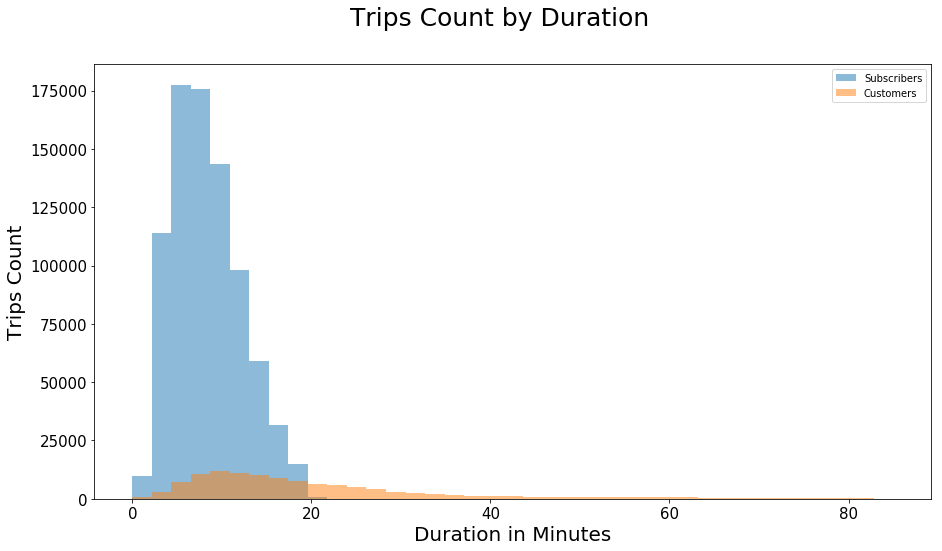

In [42]:
bins = np.linspace(0, 85, 40)
pyplot.rc('xtick', labelsize=15) 
pyplot.rc('ytick', labelsize=15) 

durations_hist = pyplot.figure(figsize = (15, 8))
pyplot.hist(subscriber_durations_mod.duration_min, bins, alpha=0.5, label='Subscribers')
pyplot.hist(customer_durations_mod.duration_min, bins, alpha=0.5, label='Customers')
durations_hist.suptitle('Trips Count by Duration', size = 25)
pyplot.xlabel('Duration in Minutes', size = 20)
pyplot.ylabel('Trips Count', size =  20)
pyplot.legend(loc='upper right')


In [8]:
#Calculate the percentage of Customer data that overlaps with Subscriber data in the durations plot above:
customer_durations_mod[customer_durations_mod.duration_min <= subscriber_duration_max].duration_min.count()/customer_durations.duration_min.count()

0.5214423027724784

From the outliers removal and additional calculations, we have the following results:
1. 93.37% of Subscribers trips have a duration of between 1 and 19.72 minutes. 
2. 52.14% of Customers trips have a duration of between 1 and 19.72 minutes.  
3. In the duration range of 1 to 19.72 minutes, the number of subscriber trips is significantly greater than that of customer trips.  

From this initial analysis, we see that ~86% of all trips are subscriber trips and most subscriber trips(93%+) have a duration of 1-20 minutes.  Customer trips, which comprise of ~14% of all trips, have a median duration of 18.83 minutes which is more than twice the subscriber trips duration of 8.02 minutes.  Only ~52% of customer trips have durations between 1-20 minutes, which means that as much as 48% of customer trips have durations that are greater than 93% of subscriber trips. 

Because we do not have subscriber and customer IDs in any of the tables, we can only speculate the definition of a commuter from this analysis.  The current pricing of https://www.fordgobike.com/ bike rentals is as follows:

- \$2 for a one way trip
- \$9.95 for a 1 day pass (for unlimited \$30 rides and \$3 per each additional 15 min)
- \$19.95 for a 3 day pass (for unlimited \$30 rides and \$3 per each additional 15 min)
- \$15 for a one month membership (for unlimited 45-minute rides and \$3 per each additional 15 min)

Therefore, given the higher bike ride frequency needs of a commuter, it is reasonable to assume that a commuter is much more likely to be a monthly or annual subscriber who pays one monthly price of \$15 for unlimited 45 minute rides, resulting in the lowest cost per day than any other option that is currently offered. In addition, given that only 52% of customer trips are between 1-20 min, while 93 percent of subscriber trips are between 1-20 minutes, it is highly improbable that a commuter who may be riding to work 4-5 days per week will remain a customer.  It is important to note that Customers may also be taking bike rides between the 1-20 min duration range, because they are a) considering becoming subscribers as commuters or b) do not wish to incur additional fees of durations greater than 30 min.

**Based on the analysis here, I will define the 1st criteria of a commuter trip as one that is taken by mostly subscribers, a small percentage of customers, and should have a duration of no more than 20 minutes.**

### 1.2 What times of the day are commuting times?

To determine commuting times, let's first take a look at which hours are the most rides starting.  To check that my query results are logical, I will group the entire data set by all 24 hours using the following query:

In [14]:
! bq query --use_legacy_sql=false ' \
SELECT \
  EXTRACT(HOUR FROM start_date) as start_hour, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY start_hour \
ORDER BY trips DESC'

Waiting on bqjob_r463dbe703ac4d982_000001663d6a84d7_1 ... (1s) Current status: DONE   
+------------+--------+
| start_hour | trips  |
+------------+--------+
|          8 | 132464 |
|         17 | 126302 |
|          9 |  96118 |
|         16 |  88755 |
|         18 |  84569 |
|          7 |  67531 |
|         15 |  47626 |
|         12 |  46950 |
|         13 |  43714 |
|         10 |  42782 |
|         19 |  41071 |
|         11 |  40407 |
|         14 |  37852 |
|         20 |  22747 |
|          6 |  20519 |
|         21 |  15258 |
|         22 |  10270 |
|         23 |   6195 |
|          5 |   5098 |
|          0 |   2929 |
|          1 |   1611 |
|          4 |   1398 |
|          2 |    877 |
|          3 |    605 |
+------------+--------+


Based on this query result, we see the following:
1. The 6 most popular start times are during the following hours - 8am, 5pm, 9am, 4pm, 6pm, 7am. The popular morning start hours reasonably align with commuting to the office before work, and the afternoon popular start times reasonably align with commuting to home from office after work.  
2. We can see that the start times are indeed in the correct PST time zone.  As expected, the hours 12am to 5am are the least popular start times as that is during the hours when most people sleep.  

As the majority of trips are taken by subscribers, we will investigate in the next section the percentage of subscribers that take popular routes during popular times.  From these start time hour summary results, it is reasonable to speculate that commuters are most likely to start their morning commutes going to work during the most popular morning hours and to start their evening commutes leaving work during the most popular afternoon hours.  

**Using the top 5 popular start time hours, I will define the 2nd criteria for a commuter trip as one with a morning start time between 7am and 10am or a evening start time of between 4pm and 7pm.**

The morning time period of 7am to 10am will be referred to as the morning rush hours while the afternoon time period of 4pm to 7pm will be referred to as the afternoon rush hours.  I decided to limit morning rush hours to 3 and afternoon rush hours to 3 for symmetry.  

### 1.3 What popular routes during commuting times have trip lengths that are considered commuter trips?

To narrow down the top commuter routes, lets first take a look at the top 5 most popular routes during the morning rush hours and the top 5 most popular routes during the afternoon rush hours.  The popularity will be determined by the number of trips per route during these times, and for each set of 5 queried we will also examine the number of customers versus subscribers. 

- first a query of the top 5 routes with the most trips count and their average trip durations during the morning rush:

In [26]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  start_station_id, start_station_name, end_station_id, end_station_name, \
  count(*) as trips, \
  round(avg(duration_sec/60),2) as avg_duration_min \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE TIME(start_date) >= "07:00:00" AND TIME(start_date) <= "10:00:00" \
GROUP BY start_station_id, start_station_name, end_station_id, end_station_name \
ORDER BY trips DESC \
LIMIT 5' > top5morning.csv

Waiting on bqjob_r577d17491c2ae680_000001663dc56158_1 ... (1s) Current status: DONE   

In [9]:
top_5_am = pd.read_csv('top5morning.csv')
#merging the start_station_id and end_station_id into one column called route_id
top_5_am['route_id'] = top_5_am.start_station_id.astype(str)+'-'+top_5_am.end_station_id.astype(str)
top_5_am.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)

- next, a query of the top 5 routes by most trips count plus columns for number of subscriber trips and customer trips, during the morning rush:

In [28]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT start_station_id, end_station_id, \
  sum(trips) as total_trips, \
  sum(case when subscriber_type = "Subscriber" then trips else 0 end) as subscriber_trips, \
  sum(case when subscriber_type = "Customer" then trips else 0 end) as customer_trips \
FROM ( \
SELECT \
  start_station_id, end_station_id, subscriber_type, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE TIME(start_date) >= "07:00:00" AND TIME(start_date) <= "10:00:00" \
GROUP BY start_station_id, end_station_id, subscriber_type \
) \
GROUP BY start_station_id, end_station_id \
ORDER BY total_trips desc \
LIMIT 5' > top5morningsc.csv

Waiting on bqjob_r393ee91dca19e188_000001663dc5bb29_1 ... (2s) Current status: DONE   

In [10]:
top_5_am_sc = pd.read_csv('top5morningsc.csv')
#merging the start_station_id and end_station_id into one column called route_id
top_5_am_sc['route_id'] = top_5_am_sc.start_station_id.astype(str)+'-'+top_5_am_sc.end_station_id.astype(str)
top_5_am_sc.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)

- lastly, I merge both tables from the above queries to check that the top 5 morning trips meet the criteria I have defined in 1.1 and 1.2.  

In [11]:
morning_commutes = top_5_am.merge(top_5_am_sc, on = 'route_id')
#removing the trips count repeat column:
morning_commutes.drop(['trips'], axis = 1, inplace = True)
morning_commutes.set_index('route_id', inplace=True)
#adding column for the percentage of subscribers:
morning_commutes['subscribers_percentage'] = round(morning_commutes.subscriber_trips/morning_commutes.total_trips, 4)*100
morning_commutes.head()

,start_station_name,end_station_name,avg_duration_min,total_trips,subscriber_trips,customer_trips,subscribers_percentage
route_id,,,,,,,
50-61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.59,4556,4489,67,98.53
74-61,Steuart at Market,2nd at Townsend,8.62,3796,3746,50,98.68
69-65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.59,3548,3496,52,98.53
70-51,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,10.46,3372,3349,23,99.32
70-55,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),11.39,3137,3099,38,98.79


From here, we see that the top 5 most popular routes during the morning rush, between 7am and 10am, all consists of 98% or greater subscriber trips.  This fits the criteria that I defined in 1.1, which is that commuter trips should should be taken by mostly subscribers and potentially a small percentage of customers.  The average trip duration of all top 5 morning routes is between 4 minutes and 12 minutes, which also fits the criteria I defined in 1.1, which is that commuter trips should be between 1 and 20 minutes.  In conclusion, I would consider all 5 of these routes to be commuter trips. 

- next, I will create the same table containing average duration, total trips count, subscriber trips count, customer trips and subscribers trips percentages for the evening rush.  First I query the top 5 trips by count during the evening rush:

In [21]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  start_station_id, start_station_name, end_station_id, end_station_name, \
  count(*) as trips, \
  round(avg(duration_sec/60),2) as avg_duration_min \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE TIME(start_date) >= "16:00:00" AND TIME(start_date) <= "19:00:00" \
GROUP BY start_station_id, start_station_name, end_station_id, end_station_name \
ORDER BY trips DESC \
LIMIT 5' > top5evening.csv

Waiting on bqjob_r7ff510f232edbaae_000001663dbf06ee_1 ... (0s) Current status: DONE   

In [12]:
top_5_pm = pd.read_csv('top5evening.csv')
#merging the start_station_id and end_station_id into one column called route_id
top_5_pm['route_id'] = top_5_pm.start_station_id.astype(str)+'-'+top_5_pm.end_station_id.astype(str)
top_5_pm.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)

- again, a query of the top 5 routes by most trips count plus columns for number of subscriber trips and customer trips, during the evening rush:

In [23]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT start_station_id, end_station_id, \
  sum(trips) as total_trips, \
  sum(case when subscriber_type = "Subscriber" then trips else 0 end) as subscriber_trips, \
  sum(case when subscriber_type = "Customer" then trips else 0 end) as customer_trips \
FROM ( \
SELECT \
  start_station_id, end_station_id, subscriber_type, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE TIME(start_date) >= "16:00:00" AND TIME(start_date) <= "19:00:00" \
GROUP BY start_station_id, end_station_id, subscriber_type \
) \
GROUP BY start_station_id, end_station_id \
ORDER BY total_trips desc \
LIMIT 5' > top5eveningsc.csv

Waiting on bqjob_r722dbba73a2ed33b_000001663dc143df_1 ... (0s) Current status: DONE   

In [13]:
top_5_pm_sc = pd.read_csv('top5eveningsc.csv')
#merging the start_station_id and end_station_id into one column called route_id
top_5_pm_sc['route_id'] = top_5_pm_sc.start_station_id.astype(str)+'-'+top_5_pm_sc.end_station_id.astype(str)
top_5_pm_sc.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)

- lastly, I merge both tables from the above queries to check that the top 5 evening trips meet the criteria I have defined in 1.1 and 1.2.

In [14]:
evening_commutes = top_5_pm.merge(top_5_pm_sc, on = 'route_id')
#removing the trips count repeat column:
evening_commutes.drop(['trips'], axis = 1, inplace = True)
evening_commutes.set_index('route_id', inplace=True)
#adding column for the percentage of subscribers:
evening_commutes['subscribers_percentage'] = round(evening_commutes.subscriber_trips/evening_commutes.total_trips, 4)*100
evening_commutes.head()

,start_station_name,end_station_name,avg_duration_min,total_trips,subscriber_trips,customer_trips,subscribers_percentage
route_id,,,,,,,
61-50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),8.28,4310,4137,173,95.99
51-70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),10.99,4067,3983,84,97.93
60-74,Embarcadero at Sansome,Steuart at Market,7.84,4031,3778,253,93.72
74-70,Steuart at Market,San Francisco Caltrain (Townsend at 4th),12.25,3440,3349,91,97.35
55-70,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),10.92,3338,3283,55,98.35


From here, we see that the top 5 most popular routes during the evening rush, between 4pm and 7pm, all consists of 95% or greater subscriber trips. This also fits the criteria that I defined in 1.1, which is that commuter trips should should be taken by mostly subscribers and potentially a small percentage of customers. The average trip duration of all top 5 evening routes is between 7 minutes and 13 minutes, which also fits the criteria I defined in 1.1, which is that commuter trips should be between 1 and 20 minutes. In fact, all 5 average durations are fairly close to the mean and median of most subsriber trips as seen in the 1.1 analysis.  I would also consider all 5 of these trips to be commuter trips, based on my defined criteria in the previous 2 sections. 

### Question 1 Answer

For the answer of the top 5 commuter trips, I think that its perfectly valid to define 5 commuter routes for the morning rush independently of 5 commuter trips for the evening rush. In that case, my response here would be the 2 dataframes created - morning_commutes and evening_commutes.  

However, I think it would be interesting to compare the trip counts for all 5 routes so see how many routes have return trips in the top 5.  For this comparison, I will combine the two dataframes into one:

In [15]:
#first, I will create a column in both data frames called rush_period
#with a value of evening or morning to distinguish which rush period the route is most popular

morning_commutes['rush_period'] = 'morning'
evening_commutes['rush_period'] = 'evening'

top_routes_combined = morning_commutes.append(evening_commutes).sort_values(by=['total_trips'], ascending = False)
top_routes_combined.head(10)

,start_station_name,end_station_name,avg_duration_min,total_trips,subscriber_trips,customer_trips,subscribers_percentage,rush_period
route_id,,,,,,,,
50-61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.59,4556,4489,67,98.53,morning
61-50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),8.28,4310,4137,173,95.99,evening
51-70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),10.99,4067,3983,84,97.93,evening
60-74,Embarcadero at Sansome,Steuart at Market,7.84,4031,3778,253,93.72,evening
74-61,Steuart at Market,2nd at Townsend,8.62,3796,3746,50,98.68,morning
69-65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.59,3548,3496,52,98.53,morning
74-70,Steuart at Market,San Francisco Caltrain (Townsend at 4th),12.25,3440,3349,91,97.35,evening
70-51,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,10.46,3372,3349,23,99.32,morning
55-70,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),10.92,3338,3283,55,98.35,evening


From this combined dataframe, it appears that 3 of the top 5 morning routes have a evening return routes also in the top 5.  These routes are:
1. Harry Bridges Plaza (Ferry Building) to 2nd at Townsend
2. San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale)
3. San Francisco Caltrain (Townsend at 4th to Embarcadero at Folsom	

One way to consider the top 5 routes is to consider a morning route and its return evening route as independent routes.  While it is resonable to presume that many commuters takes the same route but in the opposite direction in the evening, there could also be many commuters who take different return routes from office to home in the evening.  They may be motivated by personal needs such as exercise habits, grocery shopping, other errands, or traffic patterns.  Thus, without subscriber identification data, we actually do not have a sense of how many of the evening return trips are taken by the same subscribers who take the morning trips.  If we consider the morning routes and evening routes as different routes, then the top 5 commuter trips from morning and evening rush periods combined are:

In [16]:
top_routes_combined.head(5)

,start_station_name,end_station_name,avg_duration_min,total_trips,subscriber_trips,customer_trips,subscribers_percentage,rush_period
route_id,,,,,,,,
50-61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.59,4556,4489,67,98.53,morning
61-50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),8.28,4310,4137,173,95.99,evening
51-70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),10.99,4067,3983,84,97.93,evening
60-74,Embarcadero at Sansome,Steuart at Market,7.84,4031,3778,253,93.72,evening
74-61,Steuart at Market,2nd at Townsend,8.62,3796,3746,50,98.68,morning


If we decide to consider return routes as the same route, then we would not double count the return route with route_id 61-50 in the table above.  the top 5 commuter trips from morning and evening rush periods combined would then be:

In [17]:
top_5_unique = top_routes_combined[0:1].append(top_routes_combined[2:6])
top_5_unique.head(5)

,start_station_name,end_station_name,avg_duration_min,total_trips,subscriber_trips,customer_trips,subscribers_percentage,rush_period
route_id,,,,,,,,
50-61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.59,4556,4489,67,98.53,morning
51-70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),10.99,4067,3983,84,97.93,evening
60-74,Embarcadero at Sansome,Steuart at Market,7.84,4031,3778,253,93.72,evening
74-61,Steuart at Market,2nd at Townsend,8.62,3796,3746,50,98.68,morning
69-65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.59,3548,3496,52,98.53,morning


## Question 2 - What are your recommendations for offers (justify based on your findings)?

To increase ridership, there are a few stategic directions to consider:
1. Increasing the number of customers
    1. Better pricing for first-time users or limited time users
    2. Tier pricing for single rides
    3. Improving infrastructure, such as bike availability
2. Increasing the number of subscribers from customers
    1. Target customers who are taking popular routes and offer subscription deals to them
    2. Offering lower price subsriptions
3. Increase subsribers subscription periods
    1. Improve infrastructure for most populous zip codes

### 2.1.A - Better pricing for customers

One thing that I found rather baffling the current pricing at https://www.fordgobike.com/pricing is that the 3-day pass is \$19.95 for rides with a limit of 30 minutes and \$3 for each additional minute while a monthly pass is $15 for rides with a limit of 45 minutes and \$3 for each additional minute.  As a first time customer who may wish to ride a bike for 2-3 days, say for touring the bay area, I am completely unincentivized to sign up for the 3-day pass where I will need to pay \$5 more for a shorter time limit to my rides.  In fact given this pricing structure, it is highly possible that multi-day first time users may sign up for a subscription instead.  

While this confusing pricing scheme may appear to be a tactic to gain subscribers, it could lead to possible profit loss.  First, the current pricing scheme artificially inflates the number of subscribers with short term customers, which means that there will be more wasted effort to target subscribers with promotions later.  Secondly, there is actually a \$5 revenue loss from each multi-day customer.  

The pricing scheme should instead incentivize more short-term customers to purchase the 1 day or 3 day passes at their current prices (or greater), while not causing a significant detriment to the current subscribers count.  We can consider adding an additional pricing tier to detect customers that are potential subscribers.  

From dataframes created in 1.1, we have that:

In [18]:
subscriber_durations[subscriber_durations.duration_min<=30].duration_min.count()/subscriber_durations.duration_min.count()

0.993713090681936

In [19]:
customer_durations[customer_durations.duration_min>30].duration_min.count()/customer_durations.duration_min.count()

0.30709236965404324

From the calculations above, we see that ~99.3% of subscribers take rides that are 30 minutes or less.  On the otherhand there is approximately 30.7% of customers who take rides that are more than 30 minutes.  Therefore the current pricing may actually turn away customers who wish to take long term rides, due to the additional \$3 penalty for rides past a time limit.  Also, I can recall from 1.1 that within the 85th percentile of customers, ride durations are as long as 80+ minutes.  

Therefore, I would propose the following pricing changes:
1. Keep the monthly subscription price at \$15 but limit rides to 30 minutes.  
2. \$7.95 for 24 hours and \$11.95 for 3 days for unlimited rides up to 20 minutes plus \$3 for every 15 minutes after
3. \$9.95 for 24 hours and \$19.95 for 3 days for unlimited rides up to 45 minutes plus \$3 for every 15 minutes after
4. \$14.95 for 24 hours and \$29.95 for 3 days for unlimited rides of any length

Change (1) will not lead to a significant loss of subscribers, as this change would only affect 6.3% of rides.  To ensure that no subscribers are lost, I will discuss introducing a second tier monthly price for subscribers in section 2.2.  However change (1) is necessary to make the pricing for (2) through (4) more appealing.  (2) is designed to filter out customers who actually live in the Bay area and are potential subscribers, and gives these customers an opportunity to try out the bike share service before committing to a monthly membership. This will also help with narrowing down the customer segment for targeting when offering subscription deals.  (3) is the current customer pricing but has a greater time limit to attract true short term users.  (4) is a more appealing offer that can increase ridership of short term users even further by providing the added convenience of never needing to return a bike during access pass window. 

### 2.1.B Tiered Pricing for Single Rides

Currently, the pricing for a single ride, according to https://www.fordgobike.com/ is \$2 for a 30 min ride, with additional \$3 per 15 min.  The site is also promoting this price as a limited time offer, and mentions that the regular price is actually \$3 for the first 30 min.  To determine if we should proposed alternate pricings for single rides, we can first take a look at the distribution of subscribers and customers trips based on starting hour:

In [2]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  EXTRACT(HOUR FROM start_date) as start_hour, \
  subscriber_type, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY start_hour, subscriber_type \
ORDER BY start_hour' > tripsbytypeperhour.csv

Waiting on bqjob_r69cd1bf54fbf9fcb_000001664ade4ae7_1 ... (1s) Current status: DONE   

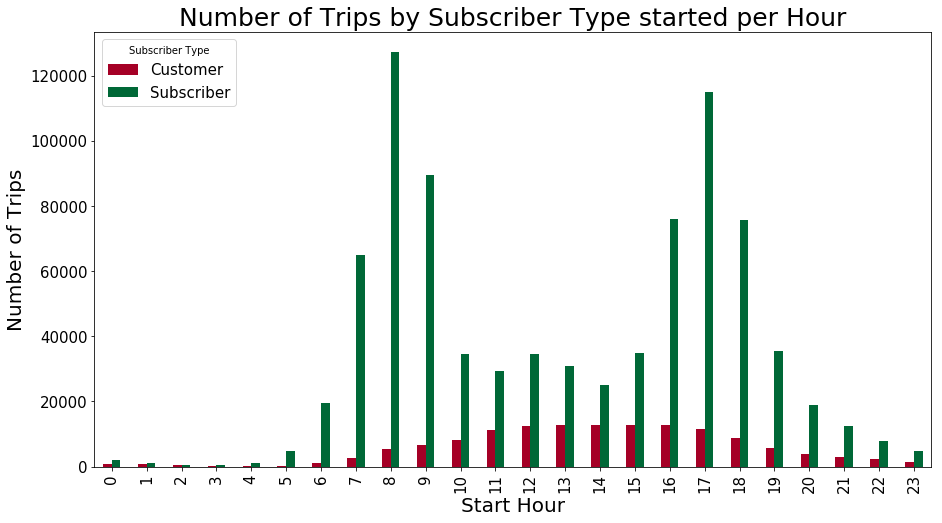

In [46]:
tripsbytypeperhour = pd.read_csv('tripsbytypeperhour.csv')
typeperhour = tripsbytypeperhour.groupby(['start_hour', 'subscriber_type'])['trips'].sum().unstack('subscriber_type')

chart_typeperhour = typeperhour.plot(kind='bar', stacked = False, colormap='RdYlGn', figsize = (15,8))
chart_typeperhour.set_xlabel('Start Hour', size=20)
chart_typeperhour.set_ylabel('Number of Trips', size=20)
chart_typeperhour.set_title('Number of Trips by Subscriber Type started per Hour', size=25)
pyplot.legend(loc=2, prop={'size': 15}, title='Subscriber Type')

chart_typeperhour 

In this plot, we see that the Subscribers' trips distibution per hour is bimodal, with one peak between start hours 7-9am and and another peak between the start hours 4-6pm, which is consistent with how I identified the morning and afternoon rush in section 1.2.  Unlike the Subscribers trip, the Customers' trip is unimodal, with a rather wide peak around the hours 12 to 4pm.  To see the customer's trip distibution per hour more clearly, I will plot it without the subscribers' data:

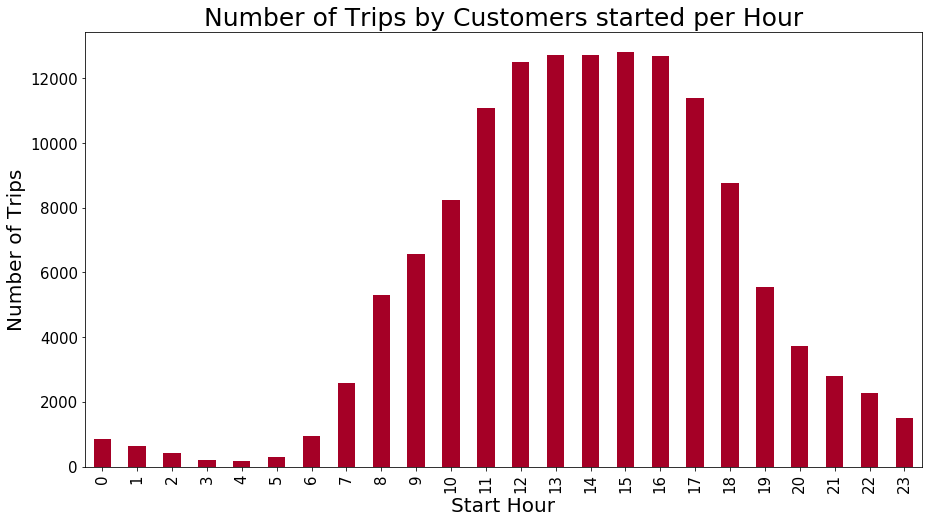

In [48]:
customersperhour = typeperhour['Customer']

chart_customersperhour = customersperhour.plot(kind='bar', stacked = False, colormap='RdYlGn', figsize = (15,8))
chart_customersperhour .set_xlabel('Start Hour', size=20)
chart_customersperhour .set_ylabel('Number of Trips', size=20)
chart_customersperhour .set_title('Number of Trips by Customers started per Hour', size=25)

chart_customersperhour

In this plot, we can see more clearly that there is a peak between the hours of 12pm and 4 pm, where the number of trips count is fairly even.  There is still a fairly high number of trips that start at 11pm, before the peak period, as well as at 5pm, immediately after the peak period.  However, there is fairly rapid decline in the number of trips before 10 am and after 6pm.  

One thing to note here is that the number of customer trips that start during the morning or evening rush periods is roughly 60% or less than that of the trips count during the 12-4pm peak period.  Without further investigation of bike availability (performed in the next section), it is difficult to say if this drop off in ridership is due to customer preferences alone, or due to bike availability.  

Independent of any infrastructure improvements, such as increasing the bike + docks count, some additional pricing proposals for single rides can be made based on this data:
1. In order to not lose potential single-ride customers, we can keep the regular pricing at \$3 a ride for limit 30 minute rides.  However,  I would recommend that this pricing be kept during the peak hours and the commuting rush periods, so from only 8am to 8pm.  
2. In addition to this, we can offer a promotion for peak time rides (12-4pm) at \$5 a ride with a longer limit, say 1-2 hours.  This is still lower than the price for a 24 hour pass, and has the potential to attract customers (say tourists) who may want to take longer rides during the day for non-commuting purposes. This is assuming that customers who are not commuters have a preference for these start times.  
3. For start times before 8am and after 8pm, the customer segment appears to be small, since this time period has the least amount of riders.  Although it is unlikely for us to gain more riders during this time period, since humans in general prefer to ride during sunlight hours, we can still attempt to promote ridership even further by lowering the single ride price to \$1.5 per ride for the time period from 8am to 8pm. 

### 2.1.C Improving Infrastructure, such as bike or dock availability.  

Adding available bikes and docks for better accessibility has the potential to increase customers and subscribers. First, let's query for the number of stations owned by Ford GoBike:

In [65]:
! bq query --use_legacy_sql=false '\
SELECT \
  count(distinct station_id) \
FROM `bigquery-public-data.san_francisco.bikeshare_status`'

Waiting on bqjob_r69421788d6cec21_000001664b785d1a_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
|  75 |
+-----+


We see from this output that there are 75 total stations.  Next, I would like to compare popularity fo all of the stations with the number of total available bikes at each station.  First, let's query for the popularity of stations by the count of trips that start from each station:

In [66]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  start_station_id, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP by  start_station_id \
ORDER by start_station_id' > tripsbystation.csv

Waiting on bqjob_r18441bf9f9518992_000001664b787589_1 ... (0s) Current status: DONE   

In [68]:
tripsbystation = pd.read_csv('tripsbystation.csv')
tripsbystation.set_index('start_station_id', inplace = True)

Next, query by total bikes per station from the table bikeshare_status.  From the sync session in week 2, we know that bike_share status shows event data of a moments in time of each of the stations.  We defined the total number of bikes at any station to be docks_available + bikes_available.  Given some other exploratory analysis that I performed, I noticed that the number of bikes and docks changed overtime for some stations. Therefore, I used the max() function in the query below to select the maximum availability of all stations in the last year (2016) to give an estimate of the most recent total bike availability.  

In [78]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  station_id, \
  max(bikes_available + docks_available) as total_bikes \
FROM `bigquery-public-data.san_francisco.bikeshare_status` \
Where Date(time) >= "2016-01-01" \
Group by station_id \
Order by station_id' > totalbikesbystation.csv

Waiting on bqjob_r2333e35317cf9f60_000001664b8f47a0_1 ... (10s) Current status: DONE   

In [81]:
totalbikesbystation = pd.read_csv('totalbikesbystation.csv')
totalbikesbystation.set_index('station_id', inplace = True)

Text(0.5,1,'Number of Available Bikes by Station')

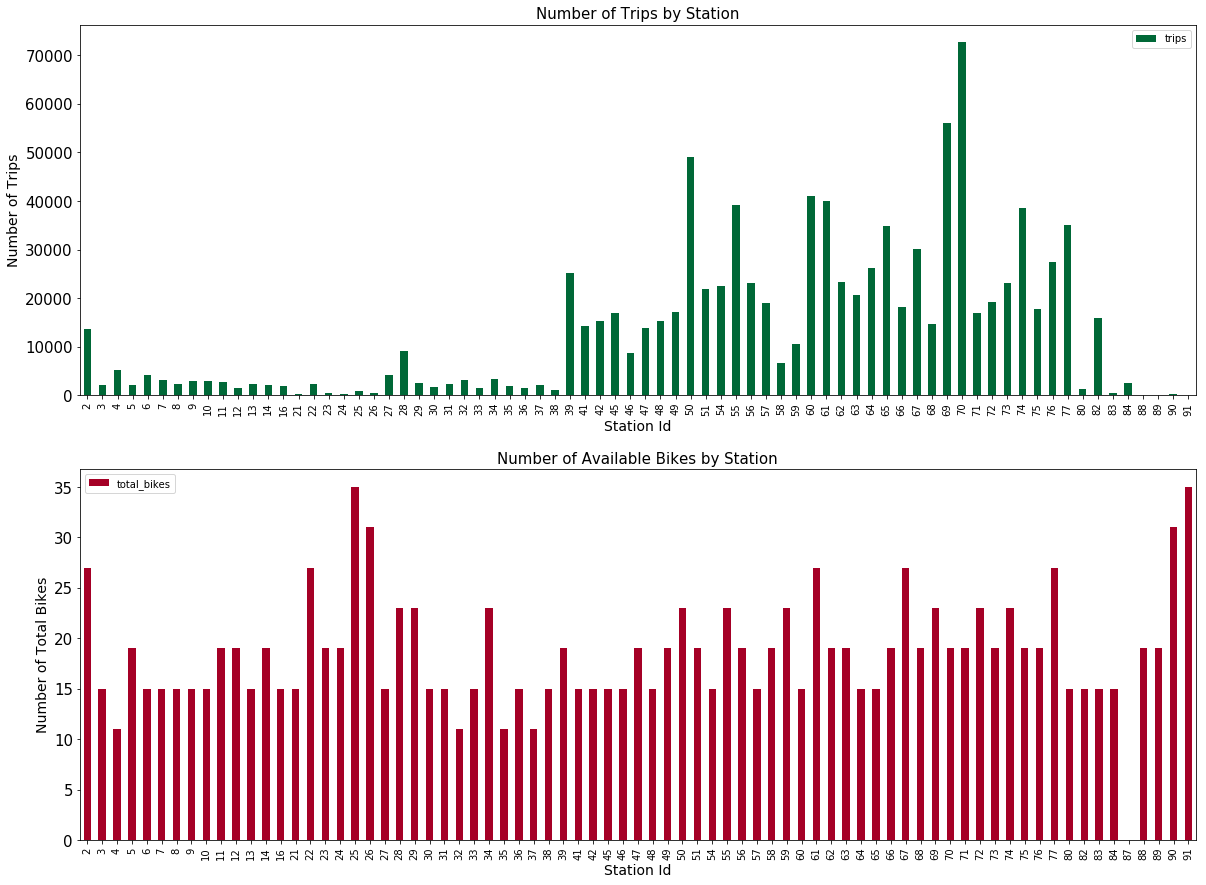

In [92]:
pyplot.rc('xtick', labelsize=10) 

stations_fig, axes = pyplot.subplots(nrows=2, ncols=1)
chart_tripsbystation = tripsbystation.plot(kind='bar', stacked = False, colormap='RdYlGn_r', figsize = (20,15), ax = axes[0])
chart_tripsbystation.set_xlabel('Station Id', size=14)
chart_tripsbystation.set_ylabel('Number of Trips', size=14)
chart_tripsbystation.set_title('Number of Trips by Station', size=15)

chart_totalbikesbystation = totalbikesbystation.plot( kind='bar', stacked = False, colormap='RdYlGn', figsize = (20,15), ax = axes[1])
chart_totalbikesbystation.set_xlabel('Station Id', size=14)
chart_totalbikesbystation.set_ylabel('Number of Total Bikes', size=14)
chart_totalbikesbystation.set_title('Number of Available Bikes by Station', size=15)

In comparing the 2 bar charts above, it appears that almost ever station is represented in both charts, with the exception of station 87 which as 0 bikes and 0 docks.  Of course as expected, station 87 is never used as a starting station.  

What is quite alarming here is that there appears to be some improproper allocation of resources.  Station 2 and Stations with Id number 39-82, with the exception of 46, 58, 59, and 80, all have significantly higher number of starting trips than all other stations.  However, we we look at the total number of bikes, most stations have 15-18, with a handful of stations that have 10, and several stations with more than 20.  Stations 2, 22, 25, 26, 90, 91 have the most bikes available but these are some of the least popular stations. The amount of bikes available at each station is in no way correlated with the popularity of the station as a starting point for trips.  Based on trips count and bikes count comparison alone, I would recommend that some bikes+docks be moved to the more popular stations.  To determine which stations need more bikes, we need another query on how many stations actually face bike shortage.  

Assuming that each row in bikeshare_status represents an instance in which a bike is rented or returned, I will refer to each row as an instance.  A station with severe bike shortage is thus a station that experiences many instances of bike_availability being low.  Suppose we set the threshold for bike shortage as instances where a station has 0 available bikes.  I will also limit the query to select instances that occur during most common ridership hours.  Based on the chart "Number of Trips by Subscriber Type started per Hour" from section 2.1.B, I will limit the query timeframe to the hours with 20000 trips or more, so the time limit of 6am to 9pm.  Then we can run the following to query to find which stations most often have no available bikes:

In [94]:
! bq query --use_legacy_sql=false --format=csv ' \
SELECT \
  station_id, \
  count(*) as instances \
FROM `bigquery-public-data.san_francisco.bikeshare_status` \
Where bikes_available = 0 AND Time(time) >= "06:00:00" AND Time(time) <= "09:00:00" \
Group by station_id \
Order by station_id' > bikeshortageinstances.csv

Waiting on bqjob_r54c3203272ec9ddb_000001664bc9120b_1 ... (2s) Current status: DONE   

In [95]:
bikeshortageinstances = pd.read_csv('bikeshortageinstances.csv')
bikeshortageinstances.set_index('station_id', inplace = True)

Next, I will create plots to compare station popularity with instances of bike shortage:

Text(0.5,1,'Stations with Bike Shortage during Daylight Hours')

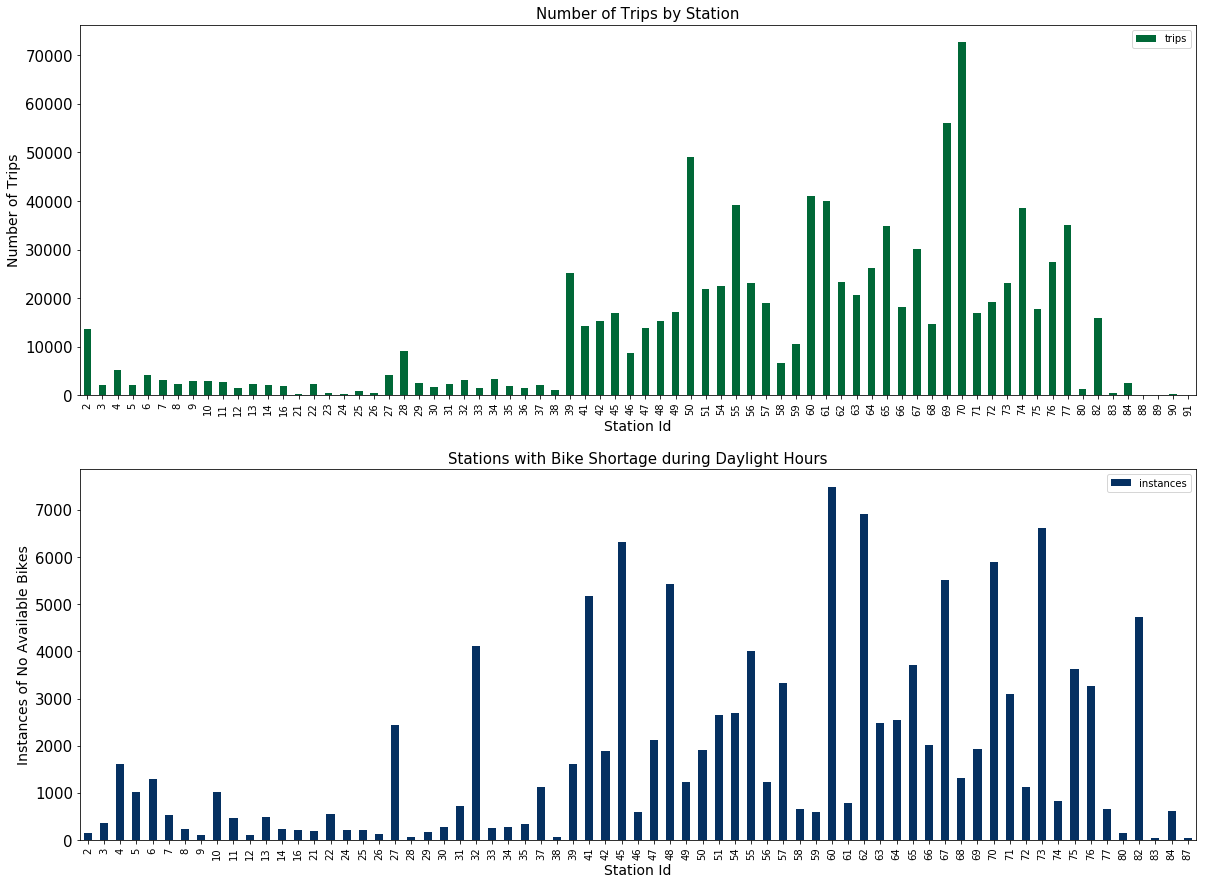

In [105]:
stations_fig_2, axes = pyplot.subplots(nrows=2, ncols=1)

chart_tripsbystation = tripsbystation.plot(kind='bar', stacked = False, colormap='RdYlGn_r', figsize = (20,15), ax = axes[0])
chart_tripsbystation.set_xlabel('Station Id', size=14)
chart_tripsbystation.set_ylabel('Number of Trips', size=14)
chart_tripsbystation.set_title('Number of Trips by Station', size=15)

chart_bikeshortageinstances = bikeshortageinstances.plot(kind='bar', stacked = False, colormap='RdBu_r', figsize = (20,15), ax = axes[1])
chart_bikeshortageinstances.set_xlabel('Station Id', size=14)
chart_bikeshortageinstances.set_ylabel('Instances of No Available Bikes', size=14)
chart_bikeshortageinstances.set_title('Stations with Bike Shortage during Daylight Hours', size=15)


The first major feature we see in the Bike Shortage plot is that stations 88-91 are not even represented, meaning that they haven no instances of bike shortage between the hours of 6am to 9pm.  Recalling from the chart of total number of bikes, these 4 stations actually have some of the largest bike counts.  Other stations with very almost negligible shortage instances are 9,12,28,38.  These stations are also amongst the least popular starting stations. In addition, we see that with the exception of 2 stations - 27 and 32 - the lower numbered stations (<39) have the fewest instances of shortage which being the least popular.  On the other hand, the higher numbered stations (39-82), with some exceptions, are the most popular starting stations while having some of the highest counts of shortage instances.  

With this analysis, I propose the following:
1.  Ford GoBike should first consider a re-allocation of resources.  This is under the assumption that moving bikes+docks to different locations will cost less than building new docs and suppling more bikes.  Bikes from the least popular stations that also faces the least instances of 0 bike availability, namely 88-91 and 9,12,28,38 are prime candidates for reduction of docks and bikes.  Their docks and bikes can then be moved to stations that have greater need.  
2. Ford GoBike has the capital to do so, they should invest in building more docks and supplying more bikes to stations that face high instances of shortage.  Anytime where a station has no bikes represents potential moments of customer loss or disgruntled subscriber who may consider quitting their memebership.  The goal of improving infrastructure should be to ensure that all stations have no instances of unavailability.  However, if resources are limited, then the stations with high popularity as starting stations and the stations that face the most instances of 0 available bikes should be targeted first.  

Given that there are only 75 stations, I feel that moving bikes from the 8 stations that are both unpopular and face negligible shortage (88-91 and 9,12,28,38) to the top 10 stations most in need, and then adding a few docks and bikes to these top 10 could already significantly change what data landscape.  Then running the analysis of popular stations compared with instances of 0 bike availability iteratively could help target additional stations that require docks+bikes adjustment.  

The top 10 stations that are most in need can be selected from the following 2 query results:

In [101]:
#top 10 most popular starting stations
! bq query --use_legacy_sql=false '\
SELECT \
  start_station_id, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP by  start_station_id \
ORDER by trips DESC \
Limit 10'

Waiting on bqjob_r350ed1158455f494_000001664bd9f64d_1 ... (0s) Current status: DONE   
+------------------+-------+
| start_station_id | trips |
+------------------+-------+
|               70 | 72683 |
|               69 | 56100 |
|               50 | 49062 |
|               60 | 41137 |
|               61 | 39936 |
|               55 | 39200 |
|               74 | 38531 |
|               77 | 35142 |
|               65 | 34894 |
|               67 | 30209 |
+------------------+-------+


In [103]:
#top 10 station with 0 bike availability
! bq query --use_legacy_sql=false ' \
SELECT \
  station_id, \
  count(*) as instances \
FROM `bigquery-public-data.san_francisco.bikeshare_status` \
Where bikes_available = 0 AND Time(time) >= "06:00:00" AND Time(time) <= "09:00:00" \
Group by station_id \
Order by instances DESC \
limit 10'

Waiting on bqjob_r29d1e0734b4bf10e_000001664bdb9536_1 ... (3s) Current status: DONE   
+------------+-----------+
| station_id | instances |
+------------+-----------+
|         60 |      7485 |
|         62 |      6914 |
|         73 |      6608 |
|         45 |      6324 |
|         70 |      5897 |
|         67 |      5520 |
|         48 |      5439 |
|         41 |      5178 |
|         82 |      4731 |
|         32 |      4120 |
+------------+-----------+


One simple way to select the top 10 target stations for increasing bikes and docks would be to select the top 6 from both queries, then subtracting the 2 repeat stations, resulting in 10 stations with the following IDs:

70, 69, 50, 60, 61, 62, 73, 45, 55, 67.  

### 2.2.A Offering promotions to Customers who take popular routes

In answer the first question, we only limited ourselves to the top 5 commuter routes. Due to the time limit imposed on many of these routes, our query results showed very few customers taking the same route.  If we wish to target a larger customer segment, we can expand our query to 20 most popular routes, not limited to commuting, and examine the customer vs subscriber counts for these routes.  

First, let's query the top 20 most popular routes and their average durations:

In [3]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  start_station_id, start_station_name, end_station_id, end_station_name, \
  count(*) as trips, \
  round(avg(duration_sec/60),2) as avg_duration_min \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY start_station_id, start_station_name, end_station_id, end_station_name \
ORDER BY trips DESC \
LIMIT 20' > popular20routes.csv

Waiting on bqjob_r45f9c7c485b2aa90_000001664bf06133_1 ... (1s) Current status: DONE   

In [6]:
popular20routes = pd.read_csv('popular20routes.csv')
#merging the start_station_id and end_station_id into one column called route_id
popular20routes['route_id'] = popular20routes.start_station_id.astype(str)+'-'+popular20routes.end_station_id.astype(str)
popular20routes.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)
popular20routes.set_index('route_id', inplace = True)

Next, run this query to count the number of trips taken by customers verus subscribers of the same 20 trips.

In [7]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT start_station_id, start_station_name, end_station_id, end_station_name, \
  sum(trips) as total_trips, \
  sum(case when subscriber_type = "Subscriber" then trips else 0 end) as subscriber_trips, \
  sum(case when subscriber_type = "Customer" then trips else 0 end) as customer_trips \
 FROM (\
 SELECT \
  start_station_id, start_station_name, end_station_id, end_station_name, subscriber_type, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY start_station_id, start_station_name, end_station_id, end_station_name, subscriber_type \
 )\
 GROUP BY start_station_id, start_station_name, end_station_id, end_station_name \
 ORDER BY total_trips desc \
 LIMIT 20' > popular20routesbytype.csv

Waiting on bqjob_r7c1473432a76ae8d_000001664bf29a50_1 ... (1s) Current status: DONE   

In [12]:
popular20routesbytype = pd.read_csv('popular20routesbytype.csv')
#merging the start_station_id and end_station_id into one column called route_id
popular20routesbytype['route_id'] = popular20routesbytype.start_station_id.astype(str)+'-'+popular20routesbytype.end_station_id.astype(str)
popular20routesbytype.drop(['start_station_id', 'end_station_id'], axis = 1, inplace = True)
popular20routesbytype.set_index('route_id', inplace = True)


In [13]:
#merge the 2 tables to get one complete table with average durations and an additional column for percentage of customers
top20 = popular20routes.merge(popular20routesbytype, on = 'route_id')
#drop duplicate columns
top20.drop(['start_station_name_y', 'end_station_name_y', 'trips'], axis = 1, inplace = True)
#create new column for percentage of customers
top20['percentage_of_customers'] = round(top20['customer_trips']/top20['total_trips'], 4)*100
top20.head(20)

,start_station_name_x,end_station_name_x,avg_duration_min,total_trips,subscriber_trips,customer_trips,percentage_of_customers
route_id,,,,,,,
50-60,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,19.80,9150,5483,3667,40.08
69-65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5.11,8508,8305,203,2.39
61-50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),9.70,7620,6931,689,9.04
50-61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,10.63,6888,6332,556,8.07
60-74,Embarcadero at Sansome,Steuart at Market,8.52,6874,6200,674,9.81
65-69,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4.65,6836,6641,195,2.85
51-70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),11.63,6351,6158,193,3.04
70-50,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),13.28,6215,5709,506,8.14
74-61,Steuart at Market,2nd at Townsend,9.59,6039,5758,281,4.65


One thing to note here is that all of these routes have durations that are less than 20 minutes, which is within the limit of a commuter route, per the analysis completed in section 1.1. While most of these routes are dominated by subscribers, there are 3 of them that have a significantly higher percentage of customers than others.  These are the following 3 routes:

1. Harry Bridges Plaza (Ferry Building) to	Embarcadero at Sansome with 40% customers
2. Steuart at Market to	Embarcadero at Sansome with 16.6% customers
3. Embarcadero at Sansome to Harry Bridges Plaza (Ferry Building) with 34.6 customers

If I expanded my query to the top 100, I could potentially uncover more of these routes where there are a non-neglible number of customer trips.  In fact, any popular route taken by subscribers with a duration of less than 20 minutes could be a potential commuter route for that subset of subscribers.  If these popular routes have any non-zero amount of customers, these customers can be targeted as potential subscribers.  

Therefore I would propose the following:
1. For the top X amount of popular routes with durations less than 20 min, find routes with a signifiant number of customer trips (>10%).  For future customers that take trips along these routes, offer a one month free subscription trial, or a one month subscription trial at a significantly reduced price (perhaps \$9.95, the current 24 hour pass price rate).  In my example, for the top 20 routes, there are 3 such routes with large amongt of customer trips that can be the source of customers that can become potential subscribers. 
2. For the top X commuter routes, target any future customers taking the same route with an offer of one month free subscription trial, or a one month subscription trial at a significantly reduced price of \$9.95.  When looking at commuter routes, we may have a high chance of capturing customers who are residents of the Bay Area and are trying the bikeshare prior to committing. By offering low risk trials, they may be more motivated to become long term subscribers after one month of usage. 

### 2.2.B Offering lower price subscriptions

So far, we have targeted customers who may be taking commuter routes.  What about customers who are avid bike riders in the Bay Area and may want to rent bikes on weekends for leisure?  To discover such customers, lets run a query on trips by day of week, and the number of trips taken by customers versus subscribers.  

In [14]:
! bq query --use_legacy_sql=false --format=csv '\
SELECT \
  EXTRACT(DayofWeek FROM start_date) as day_of_week, \
  subscriber_type, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY day_of_week, subscriber_type \
ORDER BY day_of_week' > tripsdayofweek.csv

Waiting on bqjob_r4478a7a86765b43f_000001664c110d50_1 ... (1s) Current status: DONE   

In [50]:
tripsdayofweek = pd.read_csv('tripsdayofweek.csv')
tripsdayofweek.day_of_week = tripsdayofweek.day_of_week.astype(int)
tripsdayofweek.day_of_week.dtype

dtype('int64')

From the sql documentation found at https://www.w3schools.com/sql/func_mysql_dayofweek.asp, the dayofweek function has the following note - Note: 1=Sunday, 2=Monday, 3=Tuesday, 4=Wednesday, 5=Thursday, 6=Friday, 7=Saturday. Therefore, I will create a dictionary used for transforming the day_of_week output within the results table to their corresponding textual day of week:

In [52]:
day = {'1':'Sunday', '2':'Monday', '3':'Tuesday', '4':'Wednesday', '5':'Thursday', '6':'Friday', '7':'Saturday'}
change_to_day = lambda x: day[str(x)]
change_to_day(2)

'Monday'

In [60]:
tripsdayofweek['day'] = tripsdayofweek.day_of_week.apply(change_to_day)
typeperday = tripsdayofweek.groupby(['day_of_week', 'day', 'subscriber_type'])['trips'].sum().unstack('subscriber_type')
#typeperday.drop(['day_of_week'], axis = 1, inplace = True)
typeperday.head()


,subscriber_type,Customer,Subscriber
day_of_week,day,,
1,Sunday,25908,25467
2,Monday,15142,154795
3,Tuesday,14737,169668
4,Wednesday,15237,165530
5,Thursday,16612,160296


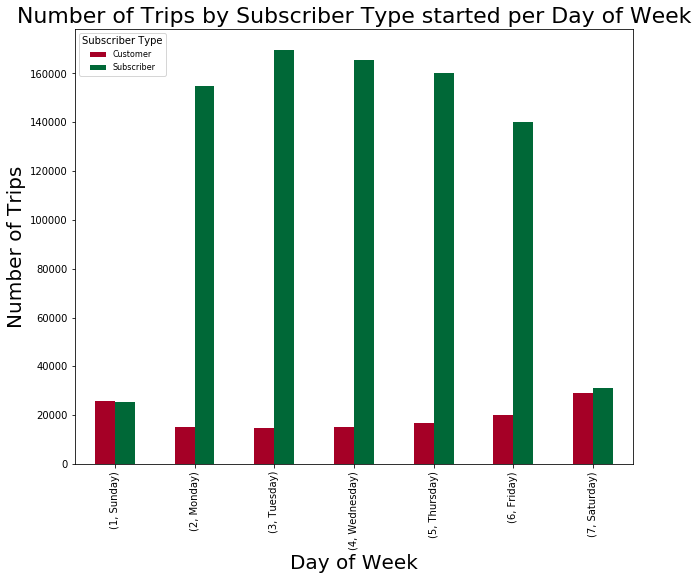

In [65]:
chart_typeperday = typeperday.plot(kind='bar', stacked = False, colormap='RdYlGn', figsize = (10,8))
chart_typeperday.set_xlabel('Day of Week', size=20)
chart_typeperday.set_ylabel('Number of Trips', size=20)
chart_typeperday.set_title('Number of Trips by Subscriber Type started per Day of Week', size=22)
pyplot.legend(loc=2, prop={'size': 8}, title='Subscriber Type')

chart_typeperday 

Perhaps as expected, we see a significant increase in amount of trips by subscribers during the weekdays than on the weekends.  This aligns with our earlier speculation that many commuters are subscribers who use the bike share service to travel between home and office during the weekday.  Also as expected, there is a significantly greater number of subscribers' during weekdays, possibly due to commute, than customers' trips. However, what this plot shows us that we have not yet seen is that the number of customer trips and subscriber trips are amost equal on the weekends.  In addition, the total number of trips (customers + subscribers) is significantly lower than that of the total number of trips during weekdays. 

In section 1.1, we found that a large amount of customers (~48%) prefer to take trips longer than 20 minutes.  In section 2.1.A, I mentioned that that there should be new pricing changes and tiers for customers to take longer rides at the propsed
3. \$9.95 for 24 hours and \$19.95 for 3 days for unlimited rides up to 45 minutes plus \$3 for every 15 minutes after
4. \$14.95 for 24 hours and \$29.95 for 3 days for unlimited rides of any length

Here, with the additional information of weekend trip counts for customers, I would also like to propse new pricing tiers for subscribers, in addition to the current \$15 per month membership pricing:

6. \$15 per month for unlimited rides on Saturday and Sunday for up to 2 hours plus \$3 for every additional 15 minutes.  
    - This is meant to attracted Bay Area residents who are currently customers but rent bikes for long rides on weekends and turn them into long term subscribers.  
    
7. \$20 per month for unlimited 30 minute rides on weekdays and 2 hour rides on weekends.  
    - In section 2.1.A. I mentioned that cutting the time limit for subscribers from 45 minutes to 30 minutes will make the other customer pricing more appealing, but could affect current subscribers who like to take longer trips. This pricing option is meant to prevent loss of existing subscribers, while also giving current subscribers more options to use the bike on both weekdays and weekends. 

### 3.1.A Increase subsribers subscription periods

Lastly, to ensure that current subscribers renew their subscriptions, we can consider improving infrastructure for our most populous zip codes.  This could also alleviate the stress at the stations that are either most popular or most likely to run out of bikes.  To find the top 20 area zip codes worth targeting, we can use a query on bikeshare_trips table's field zip_code, which is reliable for subscribers but not as much for customers.

In [71]:
! bq query --use_legacy_sql=false '\
SELECT \
  zip_code, \
  count(*) as trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
Where subscriber_type = "Subscriber" \
GROUP by zip_code \
ORDER by trips DESC \
LIMIT 20'

Waiting on bqjob_r4a25838f866b532d_000001664c48c584_1 ... (0s) Current status: DONE   
+----------+--------+
| zip_code | trips  |
+----------+--------+
| 94107    | 104037 |
| 94105    |  59582 |
| 94133    |  45242 |
| 94103    |  36517 |
| 94111    |  32615 |
| 94102    |  28717 |
| 94109    |  17696 |
| 95112    |  14108 |
| 94158    |  13035 |
| 94611    |  12882 |
| 94117    |  11754 |
| 94602    |  10685 |
| 94403    |  10624 |
| 94610    |  10333 |
| 94501    |   9891 |
| 94110    |   9528 |
| 94040    |   9449 |
| 94114    |   9037 |
| 94025    |   8879 |
| 94010    |   8819 |
+----------+--------+


Using the zip code data above, the next step would be to cross reference this with the current map and plan out new locations for stations near these zip codes.  This can increase not only accessibility but convenience for current subscribers.  Building more stations in these top 20 zip codes can not only increase both the subscribers and customers count, but can also increase the amount of subscribers who renew their membership each month or each year. 